<a href="https://colab.research.google.com/github/TrinhHoangKhang/Math-for-AI/blob/main/5.%20Image%20retrieval/Use_CLIP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Dowload dataset
!gdown 1msLVo0g0LFmL9-qZ73vq9YEVZwbzOePF
!unzip data

# Dowload packages
!pip install open-clip-torch
!pip install chromadb

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import os
from chromadb.utils.embedding_functions import OpenCLIPEmbeddingFunction
from PIL import Image

In [66]:
ROOT = 'data'
CLASS = ['Doberman', 'Orange_easy', 'Lakeland_terrier', 'Rhodesian_ridgeback']
IMG_SIZE = (448, 448)

In [3]:
embedding_function = OpenCLIPEmbeddingFunction()
def get_single_image_embedding(image):
  embedding = embedding_function._encode_image(image)
  return embedding

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [50]:
def read_img(path, size):
    im = Image.open(path).convert('RGB').resize(size)
    return np.array(im)

def get_all_img(pool_path, size):
  '''
  Given pool path, return a list of all image and its path
  '''
  img_list = []
  img_path_list = []
  for img_class in os.listdir(pool_path):
    if img_class not in CLASS:
      continue
    class_path = os.path.join(pool_path, img_class)
    for img_name in os.listdir(class_path):
      img_path = os.path.join(class_path, img_name)
      img = read_img(img_path, size)
      img_path_list.append(img_path)
      img_list.append(img)

  return np.array(img_list), np.array(img_path_list)

In [61]:
def l1_norm(query_img, target_img_ls):
  '''
  Calculate L1 norm distance between query image and target image list
  Return a list of distances
  '''
  query_img = query_img.astype(np.float32)
  target_img_ls = target_img_ls.astype(np.float32)
  axis_batch_size = tuple(range(1, len(target_img_ls.shape)))
  return np.sum(np.abs(target_img_ls - query_img), axis=axis_batch_size)

In [35]:
def l2_norm(query_img, target_img_ls):
  '''
  Calculate L2 norm distance between query image and target image list
  Return a list of distances
  '''
  query_img = query_img.astype(np.float32)
  target_img_ls = target_img_ls.astype(np.float32)
  axis_batch_size = tuple(range(1, len(target_img_ls.shape)))
  return np.sqrt(np.sum((target_img_ls - query_img)**2, axis=axis_batch_size))

In [36]:
def cosine_similarity(query_img, target_img_ls):
  '''
  Calculate Cosine similarity between query image and target image list
  Return a list of distances
  '''
  query_img = query_img.astype(np.float32)
  target_img_ls = target_img_ls.astype(np.float32)
  axis_batch_size = tuple(range(1, len(target_img_ls.shape)))
  dot_product = np.sum(query_img * target_img_ls, axis=axis_batch_size)
  query_norm = np.sqrt(np.sum(query_img**2))
  target_norm = np.sqrt(np.sum(target_img_ls**2, axis=axis_batch_size))
  return dot_product / (query_norm * target_norm)

In [27]:
# test
size = (448, 448)
img_path = '/content/data/test/African_crocodile/n01697457_18534.JPEG'
img = read_img(img_path, size)
img_embedded = get_single_image_embedding(img)
print(img_embedded)
img_embedded = np.array(img_embedded)
print(img_embedded.shape)

[0.010633490979671478, 0.1220523938536644, -0.10180678218603134, 0.01246311329305172, 0.012798557989299297, -0.03617820143699646, -0.03445688635110855, -0.005773573182523251, 0.10244280099868774, 0.052940573543310165, -0.028564829379320145, -0.023664478212594986, -0.01876218244433403, -0.02740710787475109, -0.011619765311479568, -0.011498499661684036, -0.06206217780709267, 0.0174444317817688, 0.006726972758769989, -0.01840720698237419, -0.03569100797176361, 0.023212816566228867, -0.004844202660024166, -0.009824431501328945, -0.019156236201524734, -0.01425879541784525, 0.0049207801930606365, -0.012234088964760303, -0.0034432481043040752, 0.03299947455525398, -0.04690488800406456, -0.03179838880896568, 0.003435555612668395, 0.03021794930100441, -0.01630651019513607, -0.03580109030008316, -0.020321562886238098, -0.007421642541885376, -0.06881283223628998, -0.00027244994998909533, 0.006720529869198799, -0.006829993333667517, 0.0353214330971241, -0.012271827086806297, 0.008906615898013115, 

In [33]:
def plot_results(query_img_path, result_img_paths, size):
    fig = plt.figure(figsize=(15, 9))
    fig.add_subplot(2, 3, 1)
    plt.imshow(read_img(query_img_path, size).astype(np.uint8))
    plt.title(f"Query Image: {query_img_path.split('/')[2]}", fontsize=16)
    plt.axis("off")
    for i, path in enumerate(result_img_paths, 2):
        fig.add_subplot(2, 3, i)
        plt.imshow(read_img(path, size).astype(np.uint8))
        plt.title(f"Top {i-1}: {path.split('/')[2]}", fontsize=16)
        plt.axis("off")
    plt.show()

In [59]:
def query(query_img, pool_path, distance_metric, size):
  target_img_ls, target_img_paths = get_all_img(pool_path, size)
  query_img_embedded = get_single_image_embedding(query_img)
  query_img_embedded = np.array(query_img_embedded)
  print(query_img_embedded.shape)
  target_img_ls_embedded = []
  for target_img in target_img_ls:
    target_img_embedded = get_single_image_embedding(target_img)
    target_img_ls_embedded.append(target_img_embedded)
  target_img_ls_embedded = np.array(target_img_ls_embedded)
  print(target_img_ls_embedded.shape)
  distances = distance_metric(query_img, target_img_ls)
  path_and_distance = list(zip(target_img_paths, distances))
  path_and_distance.sort(key=lambda x: x[1])
  return path_and_distance

(512,)
(25, 512)
1
2


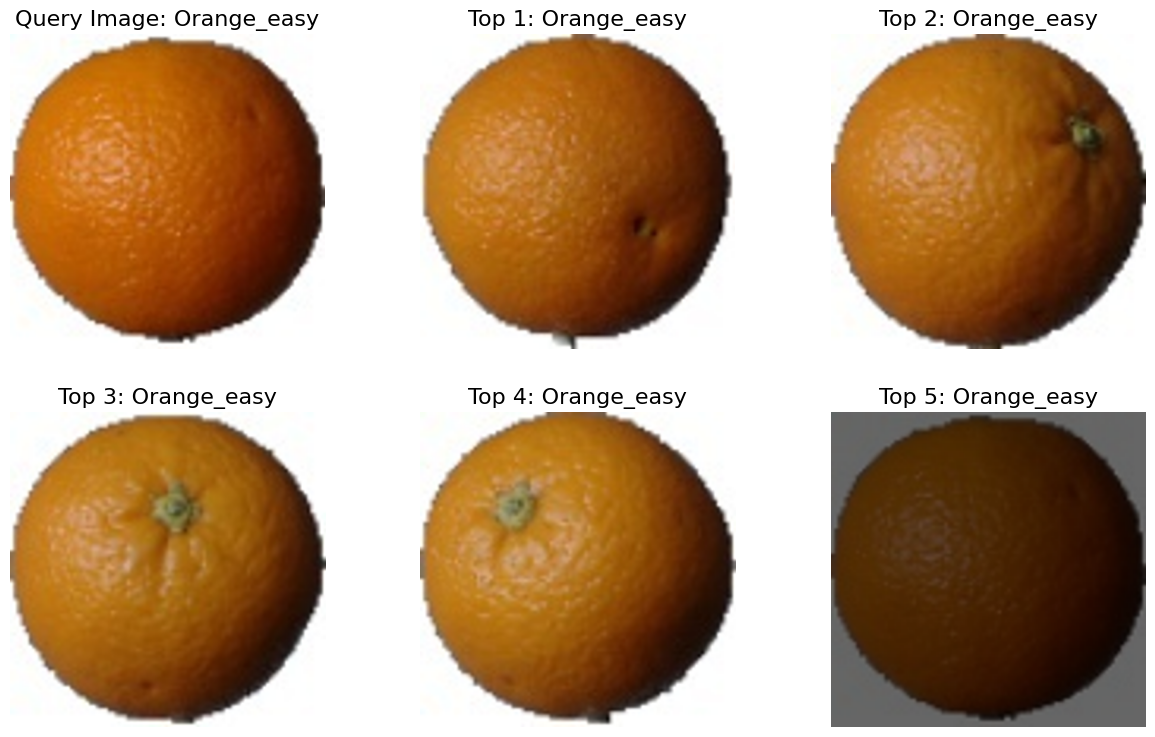

In [60]:
query_path = f"{ROOT}/test/Orange_easy/0_100.jpg"
pool_path = f"{ROOT}/train"

query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, l1_norm, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)
plot_results(query_path, img_paths[:5], IMG_SIZE)

(512,)
(35, 512)


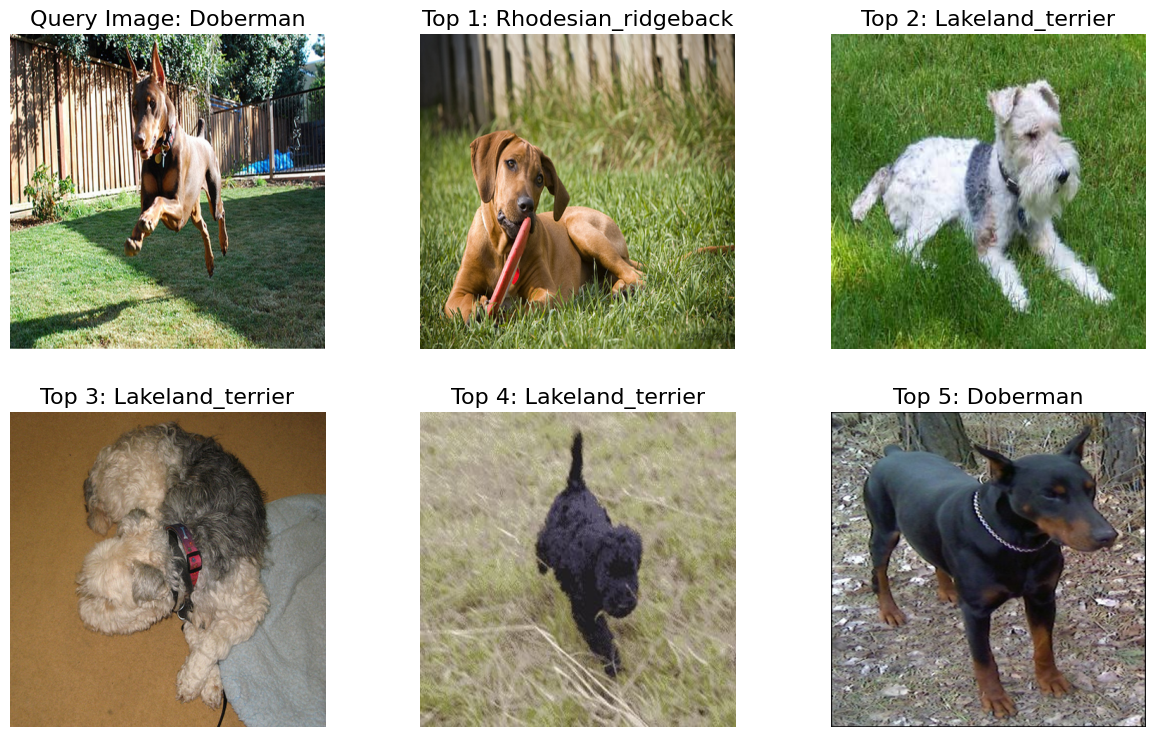

In [68]:
query_path = f"{ROOT}/test/Doberman/n02107142_52285.JPEG"
pool_path = f"{ROOT}/train"

query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, l1_norm, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)
plot_results(query_path, img_paths[:5], IMG_SIZE)

(512,)
(35, 512)


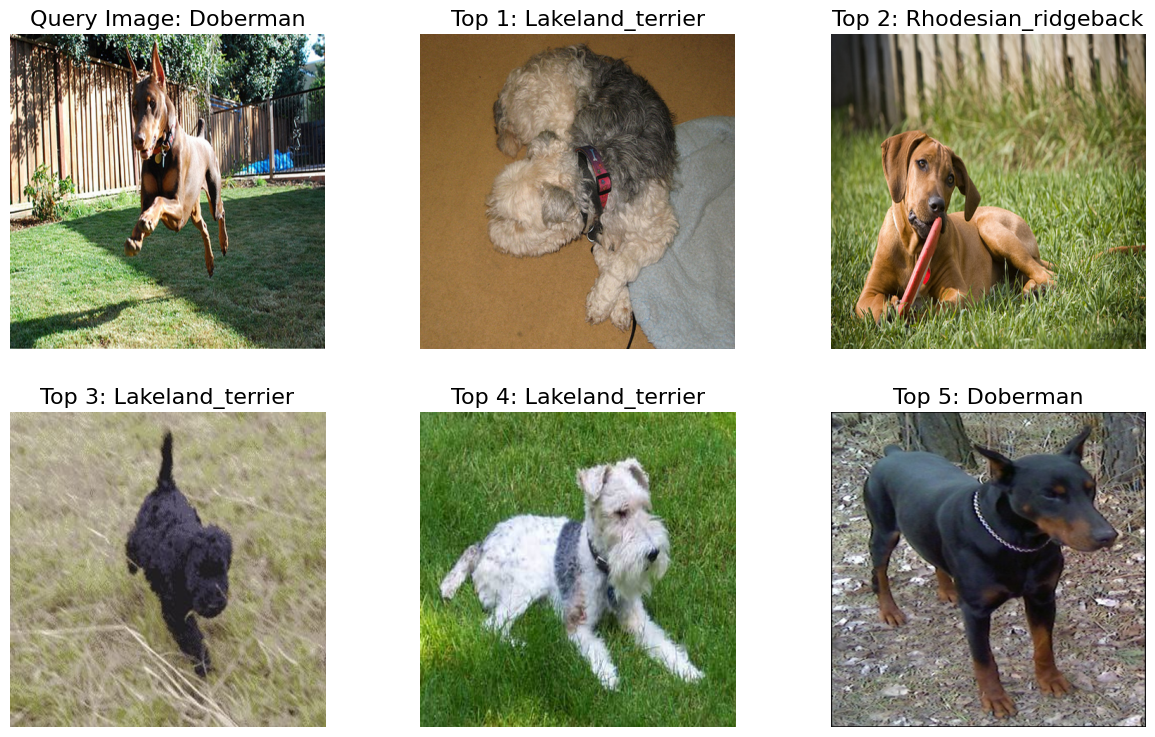

In [69]:
query_path = f"{ROOT}/test/Doberman/n02107142_52285.JPEG"
pool_path = f"{ROOT}/train"


query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, l2_norm, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)
plot_results(query_path, img_paths[:5], IMG_SIZE)

(512,)
(35, 512)


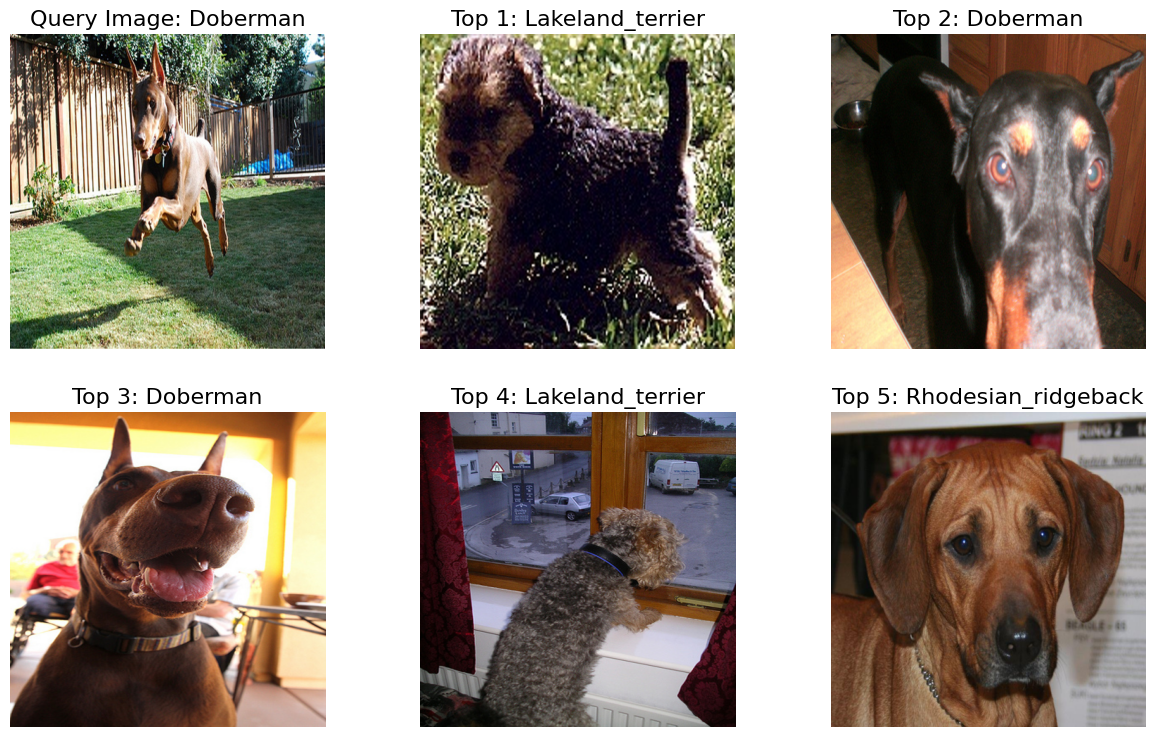

In [67]:
query_path = f"{ROOT}/test/Doberman/n02107142_52285.JPEG"
pool_path = f"{ROOT}/train"

query_img = read_img(query_path, IMG_SIZE)
img_path_and_distance = query(query_img, pool_path, cosine_similarity, IMG_SIZE)
img_paths, distances = zip(*img_path_and_distance)
plot_results(query_path, img_paths[:5], IMG_SIZE)